(The prevalence of malaria in the Gambia)=
# The prevalence of malaria in the Gambia

:::{post} Aug 04, 2024 
:tags: spatial, autoregressive, count data
:category: beginner, tutorial
:author: Jonathan Dekermanjian, bwengals (please add your name here)
:::

# Imports

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt

:::{include} ../extra_installs.md
:::

In [2]:
# These dependencies need to be installed separately from PyMC
import folium
import geopandas as gpd
import mapclassify
import rasterio as rio

from pyproj import Transformer

# Introduction

Often, we find ourselves with a sample of continuous measurements that are spatially related (Geostatistical data) and our goal is to determine an estimate of that measure in unsampled surrounding areas. In the following case-study we look at the number of individuals who test positive for malaria in our sample of 65 villages across the Gambia region and proceed with estimating the prevalence (total positive / total individuals tested) of malaria within the surrounding areas to the 65 sampled villages. 

# Data Processing

In [3]:
# load the tabular data
try:
    gambia = pd.read_csv("../data/gambia_dataset.csv")
except FileNotFoundError:
    gambia = pd.read_csv(pm.get_data("gambia_dataset.csv"))
gambia.head()

,Unnamed: 0,x,y,pos,age,netuse,treated,green,phc
0,1850,349631.3,1458055,1,1783,0,0,40.85,1
1,1851,349631.3,1458055,0,404,1,0,40.85,1
2,1852,349631.3,1458055,0,452,1,0,40.85,1
3,1853,349631.3,1458055,1,566,1,0,40.85,1
4,1854,349631.3,1458055,0,598,1,0,40.85,1


In [4]:
# For each village compute the total tested, total positive, and the prevalence
gambia_agg = (
    gambia.groupby(["x", "y"])
    .agg(total=("x", "size"), positive=("pos", "sum"))
    .eval("prev = positive / total")
    .reset_index()
)

In [5]:
gambia_agg

,x,y,total,positive,prev
0,349631.3,1458055,33,17,0.515152
1,358543.1,1460112,63,19,0.301587
2,360308.1,1460026,17,7,0.411765
3,363795.7,1496919,24,8,0.333333
4,366400.5,1460248,26,10,0.384615
...,...,...,...,...,...
60,613529.5,1473868,28,20,0.714286
61,614665.6,1482815,60,15,0.250000
62,614722.5,1474320,31,13,0.419355
63,620043.1,1497633,13,12,0.923077


In [6]:
# Create a GeoDataframe and set coordinate reference system to EPSG 4326
gambia_gpdf = gpd.GeoDataFrame(
    gambia_agg, geometry=gpd.points_from_xy(gambia_agg["x"], gambia_agg["y"]), crs="EPSG:32628"
).drop(["x", "y"], axis=1)

In [7]:
gambia_gpdf_4326 = gambia_gpdf.to_crs(crs="EPSG:4326")

In [8]:
# Get an interactive plot of the data with a cmap on the prevalence values
gambia_gpdf_4326.round(2).explore(column="prev")

/opt/miniconda3/envs/pymc_examples_contrib/lib/python3.12/site-packages/branca/utilities.py:320: RuntimeWarning: invalid value encountered in cast
  array = array.astype("uint8")



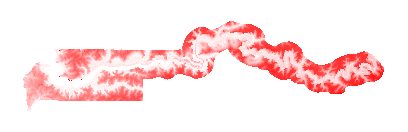

In [9]:
# Overlay the raster image of elevations in the Gambia on top of the map
m = gambia_gpdf_4326.round(2).explore(column="prev")

## Load the elevation rasterfile
in_path = "../data/GMB_elv_msk.tif"

dst_crs = "EPSG:4326"

with rio.open(in_path) as src:

    img = src.read()

    src_crs = src.crs["init"].upper()
    min_lon, min_lat, max_lon, max_lat = src.bounds
    xs = gambia_gpdf_4326["geometry"].x
    ys = gambia_gpdf_4326["geometry"].y
    rows, cols = rio.transform.rowcol(src.transform, xs, ys)

## Conversion of elevation locations from UTM to WGS84 CRS
bounds_orig = [[min_lat, min_lon], [max_lat, max_lon]]

bounds_fin = []

for item in bounds_orig:
    # converting to lat/lon
    lat = item[0]
    lon = item[1]

    proj = Transformer.from_crs(
        int(src_crs.split(":")[1]), int(dst_crs.split(":")[1]), always_xy=True
    )

    lon_n, lat_n = proj.transform(lon, lat)

    bounds_fin.append([lat_n, lon_n])

# Finding the center of latitude & longitude
centre_lon = bounds_fin[0][1] + (bounds_fin[1][1] - bounds_fin[0][1]) / 2
centre_lat = bounds_fin[0][0] + (bounds_fin[1][0] - bounds_fin[0][0]) / 2

# Overlay raster
m.add_child(
    folium.raster_layers.ImageOverlay(
        img.transpose(1, 2, 0),
        opacity=0.7,
        bounds=bounds_fin,
        overlay=True,
        control=True,
        cross_origin=False,
        zindex=1,
        colormap=lambda x: (1, 0, 0, x),
    )
)

m

In [10]:
# Pull the elevation values from the raster file and put them into a dataframe
path = "../data/GMB_elv_msk.tif"

with rio.open(path) as f:
    arr = f.read(1)
    mask = arr != f.nodata
    elev = arr[mask]
    col, row = np.where(mask)
    x, y = f.xy(col, row)
    uid = np.arange(f.height * f.width).reshape((f.height, f.width))[mask]

result = np.rec.fromarrays([uid, x, y, elev], names=["id", "x", "y", "elev"])
elevations = pd.DataFrame(result)
elevations = gpd.GeoDataFrame(
    elevations, geometry=gpd.points_from_xy(elevations["x"], elevations["y"], crs="EPSG:4326")
)

In [11]:
# Set coordinate system to EPSG 32628 and spatially join our prevalence dataframe to our elevations dataframe
elevations = elevations.to_crs(epsg="32628")

In [12]:
gambia_gpdf = gambia_gpdf.sjoin_nearest(elevations, how="inner")

In [13]:
# Set CRS to EPSG 4326
gambia_gpdf_4326 = gambia_gpdf.to_crs(crs="EPSG:4326")

In [14]:
gambia_gpdf_4326

,total,positive,prev,geometry,index_right,id,x,y,elev
0,33,17,0.515152,POINT (-16.38755 13.18541),12390,39649,-16.387500,13.187500,15.0
1,63,19,0.301587,POINT (-16.30543 13.20444),12166,38843,-16.304167,13.204167,33.0
2,17,7,0.411765,POINT (-16.28914 13.20374),12168,38845,-16.287500,13.204167,32.0
3,24,8,0.333333,POINT (-16.25869 13.53742),3429,22528,-16.262500,13.537500,20.0
4,26,10,0.384615,POINT (-16.23294 13.20603),12175,38852,-16.229167,13.204167,29.0
...,...,...,...,...,...,...,...,...,...
60,28,20,0.714286,POINT (-13.95173 13.32999),10043,33005,-13.954167,13.329167,23.0
61,60,15,0.250000,POINT (-13.94089 13.41084),7621,28927,-13.937500,13.412500,22.0
62,31,13,0.419355,POINT (-13.9407 13.33403),9875,32599,-13.937500,13.337500,25.0
63,13,12,0.923077,POINT (-13.89061 13.54459),3658,22812,-13.895833,13.537500,17.0


In [15]:
# Get relevant measures for modeling
elev = gambia_gpdf_4326["elev"].values
pos = gambia_gpdf_4326["positive"].values
n = gambia_gpdf_4326["total"].values
lonlat = gambia_gpdf_4326[["y", "x"]].values

In [16]:
# Standardize elevation values
elev_std = (elev - np.mean(elev)) / np.std(elev)

# Model Specification

We specify the following model:
$$Y_{i} \sim Binomial(n_{i}, P(x_{i}))$$
$$logit(P(x_{i})) = \beta_{0} + \beta_{1} \times Elevation + S(x_{i})$$

Where $n_{i}$ represents an individual tested for malaria, $P(x_{i})$ is the prevalence of malaria at location $x_{i}$, $\beta_{0}$ is the intercept, $\beta_{1}$ is the coefficient for the elevation covariate and $S(x_{i})$ is a zero mean field guassian process with a Matérn covariance function with $\nu=\frac{3}{2}$ that we will approximate using a Hilbert Space Gaussian Process (HSGP)

In [17]:
with pm.Model() as hsgp_model:
    _X = pm.Data("X", lonlat)
    _elev = pm.Data("elevation", elev_std)

    ls = pm.Gamma("ls", mu=20, sigma=5)
    cov_func = pm.gp.cov.Matern32(2, ls=ls)
    m0, m1, c = 40, 40, 2.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
    s = gp.prior("s", X=_X)

    beta_0 = pm.Normal("beta_0", 0, 1)
    beta_1 = pm.Normal("beta_1", 0, 1)

    p_logit = pm.Deterministic("p_logit", beta_0 + beta_1 * _elev + s)
    p = pm.Deterministic("p", pm.math.invlogit(p_logit))
    pm.Binomial("likelihood", n=n, logit_p=p_logit, observed=pos)

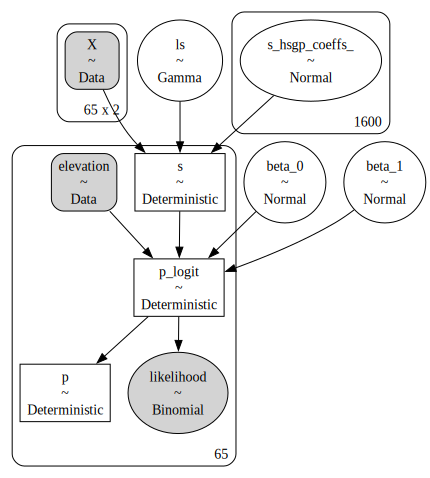

In [18]:
hsgp_model.to_graphviz()

In [19]:
with hsgp_model:
    hsgp_trace = pm.sample(1000, tune=2000, target_accept=0.95, nuts_sampler="numpyro")

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

2024-08-03 15:37:03.362812: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce = f64[4,1000,1600,1]{3,2,1,0} reduce(f64[4,1000,1,1600,1]{4,3,2,1,0} %broadcast.9, f64[] %constant.15), dimensions={2}, to_apply=%region_1.42, metadata={op_name="jit(process_fn)/jit(main)/reduce_prod[axes=(2,)]" source_file="/var/folders/h_/9hc6pmt169bdm70pz7z4s9rm0000gn/T/tmpec6a_3ly" source_line=25}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-08-03 15:37:19.424253: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 17.065954s
Constant folding an instruction is takin

In [20]:
az.summary(hsgp_trace, var_names=["ls"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ls,0.187,0.049,0.108,0.271,0.001,0.001,1940.0,2243.0,1.0


# Posterior Predictive Checks

We need to validate that our model specification properly represents the observed data. We can push out posterior predictions of the prevalence and plot them on a coordinate system to check if they resemble the observed prevalence from our sample

In [21]:
with hsgp_model:
    ppc = pm.sample_posterior_predictive(hsgp_trace)

Sampling: [likelihood]


Output()

In [22]:
posterior_prevalence = hsgp_trace["posterior"]["p"]

Refering to the map we plotted above, we can see that our posterior predictions in the figure below agree with the observed sample.

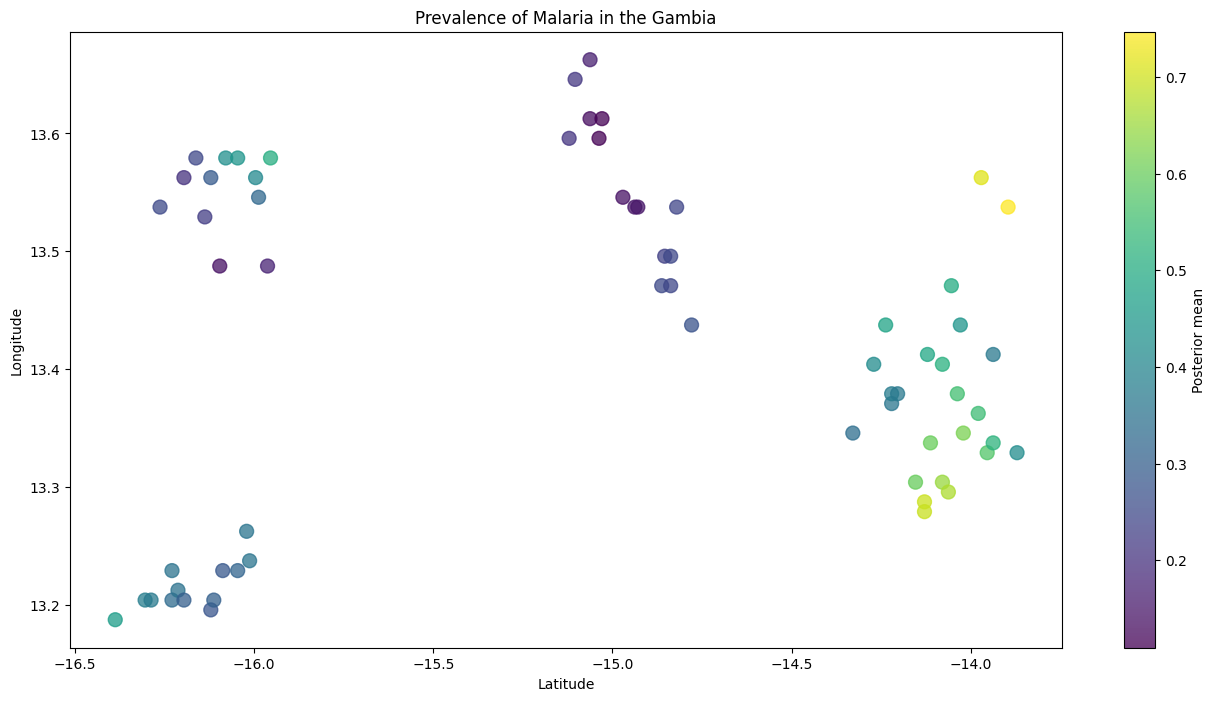

In [23]:
fig = plt.figure(figsize=(16, 8))

plt.scatter(
    lonlat[:, 1],
    lonlat[:, 0],
    c=posterior_prevalence.mean(("chain", "draw")),
    marker="o",
    alpha=0.75,
    s=100,
    edgecolor=None,
)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Prevalence of Malaria in the Gambia")
plt.colorbar(label="Posterior mean");

We can also check if the likelihood (number of individuals who test positive for malaria) agrees with the observed data. As you can see from Figure X, our posterior predictive sample is representative of the observed sample.

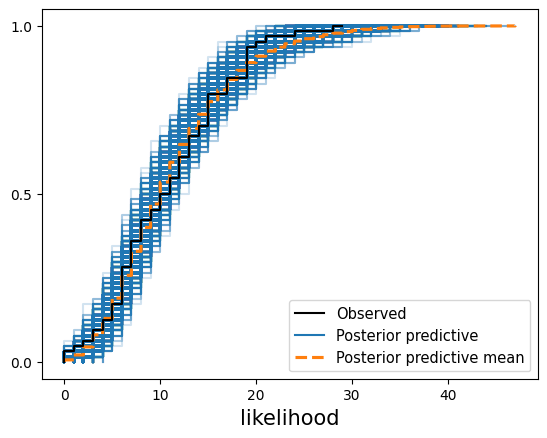

In [24]:
az.plot_ppc(ppc, kind="cumulative");

# Out-of-sample posterior predictions

Now that we have validated that we have a representative model that converged, we want to estimate the prevalence of malaria in the surrounding areas to where we have observed data points. Our new dataset will include every longitude and latitude position within the Gambia where we have a measure of elevation.

In [25]:
# Set new values for out-of-sample predictions
new_lonlat = elevations[["y", "x"]].to_numpy()
new_elev = elevations["elev"].to_numpy()
new_elev_std = (new_elev - np.mean(new_elev)) / np.std(new_elev)

In [26]:
with hsgp_model:
    pm.set_data(new_data={"X": new_lonlat, "elevation": new_elev_std})
    pp = pm.sample_posterior_predictive(hsgp_trace, var_names=["p"])

Sampling: []


Output()

In [27]:
posterior_predictive_prevalence = pp["posterior_predictive"]["p"]

We can plot our out-of-sample posterior predictions to visualize the estimated prevalence of malaria across the Gambia. In figure below you'll notice that there is a smooth transition of prevalences surrounding the areas where we observed data in a way where nearer areas have more similar prevalences and as you move away you approach zero (the mean of the guassian process).

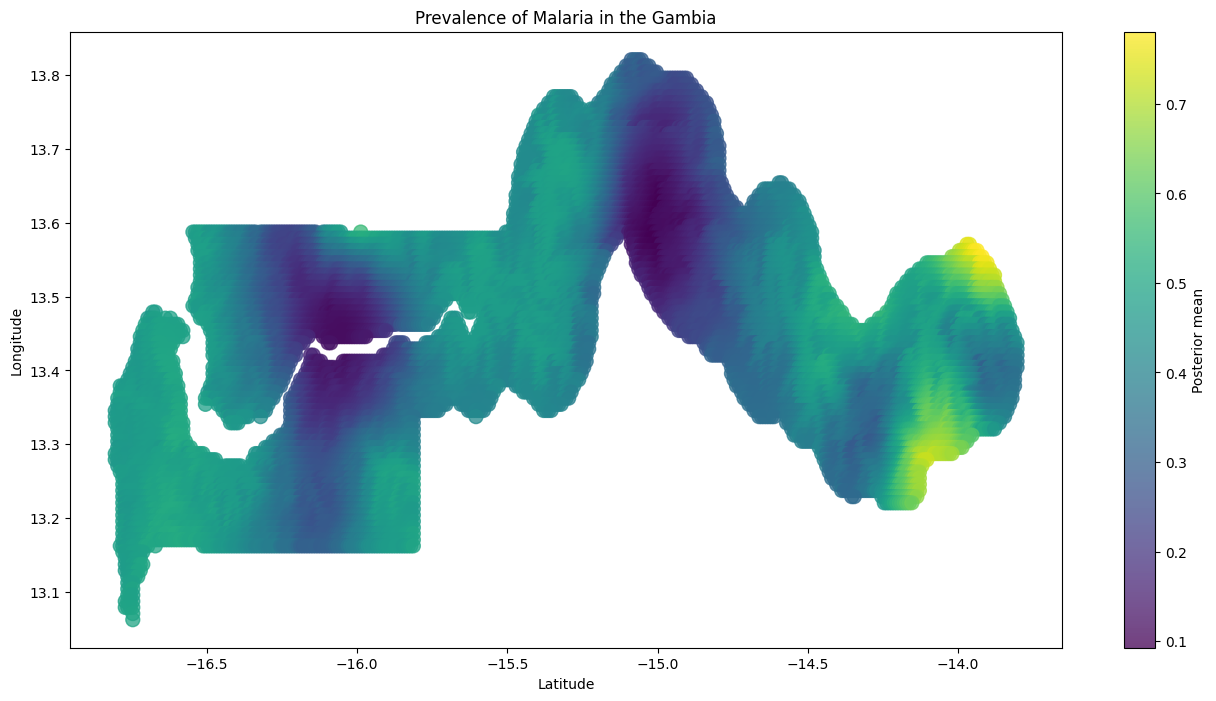

In [28]:
fig = plt.figure(figsize=(16, 8))

plt.scatter(
    new_lonlat[:, 1],
    new_lonlat[:, 0],
    c=posterior_predictive_prevalence.mean(("chain", "draw")),
    marker="o",
    alpha=0.75,
    s=100,
    edgecolor=None,
)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Prevalence of Malaria in the Gambia")
plt.colorbar(label="Posterior mean");

# Making decisions based on exceedance probabilities

One way to determine where we might decide to apply interventions is to look at exceedance probabilities of some selected threshold of malaria prevalence. These exeedance probabilities will allow us to incorporate our uncertainty in the prevalences we have estimated instead of just considering the mean of the posterior distribution. For our use case, we decide to set an exceedance threshold of 20% on the prevalance.

In [29]:
prob_prev_gt_20percent = 1 - (posterior_predictive_prevalence <= 0.2).mean(("chain", "draw"))

We can use the insights gained from the figure below to send out aid to the regions where we are most confident that the prevalence of malaria exceeds 20%.

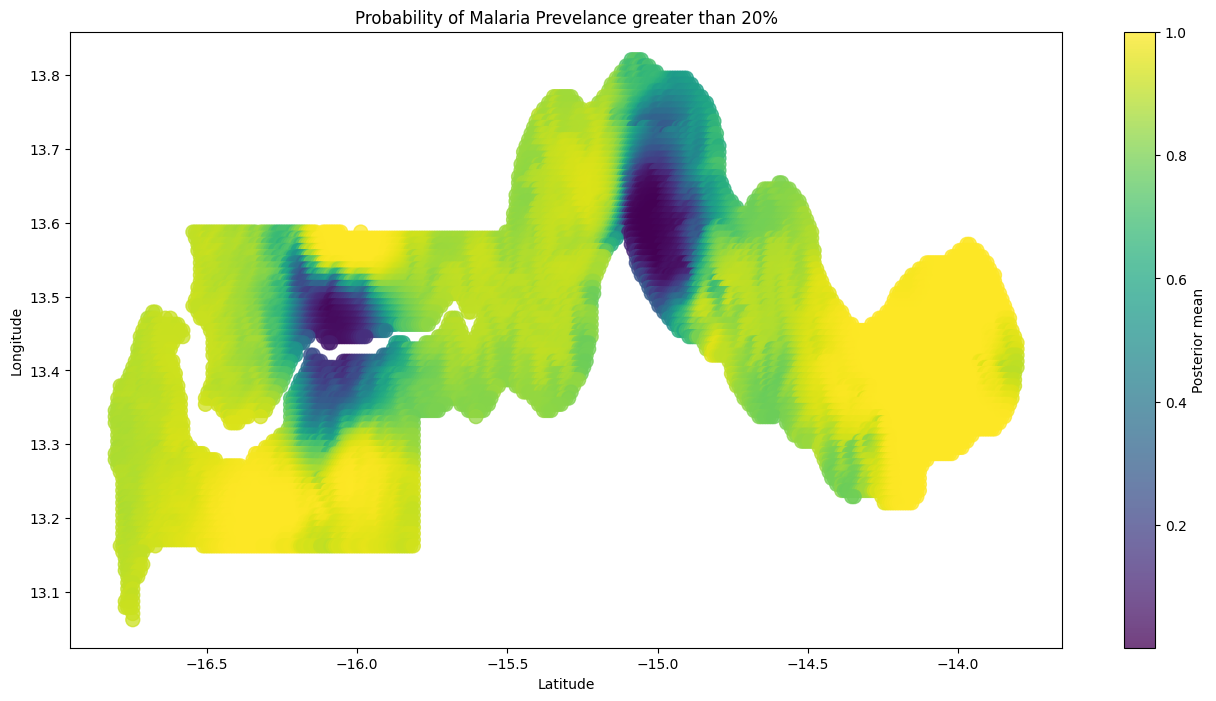

In [30]:
fig = plt.figure(figsize=(16, 8))

plt.scatter(
    new_lonlat[:, 1],
    new_lonlat[:, 0],
    c=prob_prev_gt_20percent,
    marker="o",
    alpha=0.75,
    s=100,
    edgecolor=None,
)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Probability of Malaria Prevelance greater than 20%")
plt.colorbar(label="Posterior mean");

# Conclusion

The case-study walked us through how we can utilize an HSGP to include spatial information into our estimates. Specifically, we saw how we can validate our model specification, produce out-of-sample estimates, and how we can use the whole posterior distribution to make decisions.

## Authors

* Adapted from {ref}`Geospatial Health Data: Modeling and Visualization with R-INLA and Shiny` by Dr. Paula Moraga ([link](https://www.paulamoraga.com/book-geospatial/index.html)).

# References 

:::{bibliography}
:filter: docname in docnames 
:::

# Watermark

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray

:::{include} ../page_footer.md
:::